# Simple one-way ANOVA 
- 03/16/2022
- RPneg
- TIC normalized dataset

# load library

In [5]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [6]:
library(dplyr)
library(car)
library(glue)
source("./utilis/utilis.R") # merge_by_rowName

## Read data table

In [7]:
exp_label = 'hMinImp_TICnorm_groupFil0.3_RPneg'

In [8]:
feat_df = read.csv("../../output/preproc_fultab_wt_stemCell67/FC_log2_hMinImp_TICn_groupFil0.3_RPneg_blkM_featab.csv", row.names = 1)

In [9]:
head(feat_df)

,gMean_Tn,gMean_CD8stem,gMean_CD8trans,gMean_CD8TD,log2FC_CD8stemvsTn,log2FC_CD8transvsTn,log2FC_CD8TDvsTn,log2FC_CD8transvsCD8stem,log2FC_CD8TDvsCD8stem,log2FC_CD8TDvsCD8trans,CD8TD_750K_1,CD8TD_750K_2,CD8stem_250K_1,CD8stem_300K_2,CD8trans_250K_2,CD8trans_350K_1,Tn_250K_1,Tn_250K_2,pooled_1,pooled_2,pooled_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F3,19.94507,21.54267,21.27456,21.65144,1.59759328,1.32949081,1.7063716,-0.26810247,0.1087783,0.3768808,21.90449,21.39840,21.84287,21.24247,20.65545,21.89367,20.02132,19.86882,21.57157,21.58852,21.57655
F5,20.21443,18.07694,19.24355,17.66257,-2.13748575,-0.97088423,-2.5518618,1.16660152,-0.4143760,-1.5809775,17.66257,17.66257,18.49132,17.66257,20.82452,17.66257,20.45126,19.97760,17.66257,17.66257,17.66257
F6,17.76691,18.37119,17.80263,17.15210,0.60428521,0.03572569,-0.6148085,-0.56855952,-1.2190937,-0.6505342,17.15210,17.15210,18.46719,18.27519,17.15210,18.45317,18.38171,17.15210,17.15210,17.15210,17.15210
F7,17.84827,18.47707,17.79934,17.22031,0.62879892,-0.04892554,-0.6279554,-0.67772446,-1.2567544,-0.5790299,17.22031,17.22031,18.50098,18.45316,17.22031,18.37837,18.47622,17.22031,17.22031,17.22031,17.22031
F9,21.44543,21.52757,21.46294,19.87058,0.08214261,0.01751408,-1.5748479,-0.06462853,-1.6569905,-1.5923620,19.87058,19.87058,21.53164,21.52349,21.47973,21.44615,21.31616,21.57469,21.18921,20.87058,20.96064
F10,17.50701,18.11533,18.20446,17.70459,0.60832246,0.69745412,0.1975845,0.08913165,-0.4107380,-0.4998696,16.94364,18.46554,18.11010,18.12056,18.06150,18.34743,16.94364,18.07038,17.98012,18.11866,18.21712


#### remove duplicated id

In [10]:
# This will drop all rows where the id_number value is duplicated, and keep only the first occurrence of each unique id_number value.
# feat_df = feat_df[!duplicated(feat_df['id_number']),]

##### Check the data, make sure it is already log2-transformed

In [11]:
data.df.log2 = feat_df[,grep('CD8TD|CD8stem|CD8trans|Tn',colnames(feat_df))]

## Read metadata

In [12]:
meta_df = read.csv("../../../seq/RPneg_addgrp_wtStemCell.csv")

In [13]:
rownames(meta_df) = meta_df$Sample_ID_upd
sub_meta_df = meta_df[colnames(data.df.log2),]
meta_df = sub_meta_df

------

# Summary
- check if the metadata & data matched (It should be as they have been filtered in the last notebook)
- check key metadata

In [14]:
nrow(meta_df) == ncol(data.df.log2)

[1] TRUE

In [15]:
table(meta_df['group'])

group
 CD8stem    CD8TD CD8trans       Tn 
       2        2        2        2 

### Transpose the table and prepare to merge with meta data

In [16]:
data_df.t = t(data.df.log2) # transpose the table

In [17]:
data_df.t[1:5,1:5]

,F3,F5,F6,F7,F9
gMean_Tn,19.945073,20.214429,17.7669052,17.8482676,21.44542558
gMean_CD8stem,21.542666,18.076944,18.3711904,18.4770666,21.52756819
gMean_CD8trans,21.274564,19.243545,17.8026308,17.7993421,21.46293966
gMean_CD8TD,21.651444,17.662568,17.1520966,17.2203122,19.87057769
log2FC_CD8stemvsTn,1.597593,-2.137486,0.6042852,0.6287989,0.08214261


In [18]:
ft_names = colnames(data_df.t);ft_names[1:5]

[1] "F3" "F5" "F6" "F7" "F9"

In [19]:
meta_df[1:5,]

,Sample.Type,File.Name,Sample.ID,Sample_ID_upd,cell_number,group,Comment,Path,Instrument.Method,Process.Method,Position,Inj.Vol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


----

------

# Simple one-way ANOVA
- Run all gated populations
- `ft_names`

## Prepare for the table

In [20]:
prep4anova_df = merge_by_rowName(data_df.t, meta_df) # merge data table and metadata

In [21]:
prep4anova_df_filt <- prep4anova_df[,c(
    colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
    c('group') # + critical study design factors
)] # select the columns

In [22]:
prep4anova_df_filt

,F3,F5,F6,F7,F9,F10,F11,F12,F13,F14,F16,F17,F28,F29,F39,F41,F42,F43,F64,F65,F66,F75,F76,F83,F87,F92,F93,F99,F100,F101,F102,F103,F104,F105,F106,F107,F108,F113,F119,F125,F144,F145,F160,F161,F162,F163,F168,F170,F172,F173,F174,F175,F176,F177,F180,F183,F196,F197,F198,F199,F204,F205,F206,F207,F208,F209,F210,F211,F214,F215,F216,F222,F224,F225,F226,F227,F230,F231,F232,F234,F235,F236,F237,F238,F241,F243,F244,F245,F248,F251,F256,F257,F260,F261,F262,F263,F264,F265,F266,F271,⋯,F17800,F17801,F17802,F17803,F17804,F17807,F17808,F17809,F17812,F17813,F17814,F17815,F17816,F17817,F17820,F17821,F17822,F17823,F17828,F17829,F17830,F17831,F17832,F17833,F17834,F17835,F17836,F17837,F17839,F17850,F17851,F17855,F17860,F17862,F17863,F17864,F17865,F17866,F17867,F17868,F17875,F17876,F17877,F17884,F17885,F17887,F17888,F17889,F17890,F17893,F17894,F17895,F17896,F17897,F17899,F17923,F17924,F17925,F17926,F17927,F17928,F17929,F17935,F17936,F17937,F17939,F17940,F17947,F17948,F17952,F17954,F17955,F17960,F17961,F17962,F17963,F17964,F17968,F17969,F17989,F17990,F17994,F17995,F18011,F18012,F18018,F18019,F18020,F18033,F18035,F18052,F18053,F18064,F18065,F18068,F18078,F18079,F18080,F18084,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CD8stem_250K_1,21.84287,18.49132,18.46719,18.50098,21.53164,18.11010,20.46463,23.48192,21.65999,27.92024,22.66412,23.29514,24.92351,21.61673,20.77027,20.04620,16.55508,18.82663,22.16245,21.43421,20.09669,24.86902,18.58774,25.88294,21.05989,21.41308,17.29902,20.03380,19.66737,15.18207,12.72941,14.00998,17.48357,18.04741,20.44573,19.26949,21.28661,19.32193,33.61598,23.98830,22.39908,20.75183,20.40194,16.62977,26.16208,20.88513,21.07758,17.95404,22.74332,19.82935,21.10188,22.28629,22.09784,21.58014,17.92410,23.27435,22.37041,19.23332,20.17796,18.32942,22.88455,21.54106,24.29169,23.64242,24.27607,24.00363,23.51003,19.55849,24.77211,24.18140,22.88983,21.83704,18.86251,23.80751,16.91485,21.66506,18.54908,19.65138,25.48056,21.18079,20.54168,20.49075,20.33920,20.82420,21.61679,19.84949,20.41607,18.35356,16.13722,15.99395,18.79696,16.21921,20.40662,20.06988,18.46497,20.76069,21.15342,22.52897,22.18590,31.10604,⋯,14.62378,18.64316,15.52835,18.48181,16.53699,18.00766,22.45525,22.97200,19.45292,19.91452,20.72904,19.96658,19.92159,23.84170,20.25899,23.67537,24.02066,23.80800,17.96842,17.38900,22.58846,22.06667,21.93047,17.40591,17.34139,17.21482,18.10349,22.83539,19.67774,21.18126,21.28028,20.63541,19.19919,22.02894,21.89616,20.87716,20.52362,15.43816,15.05057,17.09816,15.81270,18.11511,21.46413,20.12003,22.73781,20.77533,20.19662,20.24141,20.72862,17.01588,21.52290,20.76749,19.98840,20.99093,23.45871,15.77890,14.61941,20.53460,14.42983,18.10421,21.90968,21.95085,19.26593,22.78705,22.74157,21.51941,21.75877,22.48610,21.01144,18.65487,19.58785,17.25515,20.30031,21.80253,20.60754,21.72886,19.06975,21.64737,20.23530,

In [23]:
prep4anova_df_filt[1:8,c(ncol(prep4anova_df_filt)-1, ncol(prep4anova_df_filt))]

,F18084,group
,<dbl>,<chr>
CD8stem_250K_1,22.30331,CD8stem
CD8stem_300K_2,19.23945,CD8stem
CD8TD_750K_1,20.89983,CD8TD
CD8TD_750K_2,19.23945,CD8TD
CD8trans_250K_2,22.96821,CD8trans
CD8trans_350K_1,19.23945,CD8trans
NA,NA,NA
NA.1,NA,NA


## Run ANOVA

In [24]:
anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
    return(tryCatch(
        aov(x ~ prep4anova_df[,'group']), # no var.equal as the argument will be disregarded.
        error=function(e) NULL))
})

## Wrap ANOVA result into table

In [25]:
anova_res_list2table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Turn one-way Anova result into table
    temp_row_list <- list()
    for (i in 1:length(anova_res_list)) {
      if(is.null(anova_res_list[[i]])) {
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]),0,1) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      } else {
        anova_res.summary <- summary(anova_res_list[[i]])
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]), anova_res.summary[[1]]['F value'][[1]][1], anova_res.summary[[1]]['Pr(>F)'][[1]][1])
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      }
    }
    anova_res_df = do.call(rbind, temp_row_list)
    anova_res_df$padj <- p.adjust(anova_res_df$pval, method = 'BH') 

    anova_res_df = data.frame(anova_res_df)
    rownames(anova_res_df) = anova_res_df[,1]
    anova_res_df = anova_res_df[,2:ncol(anova_res_df)]
    return(anova_res_df)
}

#### debugging run

In [26]:
# anova_res_df = anova_res_list2table(anova_res_list, "featureID")
# dim(anova_res_df) # the dimension should be the same with original table

## Run tukey test on the `anova_res_list`

In [27]:
anova_res_list2tukeytest_table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Perform tukey test and generate the table from anova result list
    # Also current function only deals with one variable, for 2-way anova or multivariate regression, this function cannot implement
    temp_row_list <- list()
    
    # search for a valid result to get template for set up the NA stuffs
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        
        obj_list = ls(tukey.test) # There will only be one if it is 1-way anova
        obj = obj_list[[1]]
        
        tukey_oriTab = tukey.test[[obj]]
        
        padj_col_names = paste0('Tpadj_',rownames(tukey_oriTab))
        colnames = c(name_of_variable,padj_col_names)
        
        length = dim(tukey_oriTab)[1]
        
        break
        }
    } 
    
    # then go for the real run
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        tukey_oriTab = tukey.test[[obj]]
        temp_row_list[[i]] <- c(names(anova_res_list[i]), 
                                tukey_oriTab[,4] )
        } 
        else 
        {
        temp_row_list[[i]] <- c(names(anova_res_list[i]),
                                rep(NA,length) ) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        
      }
    }
    tukey_res_df = do.call(rbind, temp_row_list)
    colnames(tukey_res_df) = colnames
    
    # handling the fickled things about numeric
    tukey_res_df = data.frame(tukey_res_df)
    rownames = tukey_res_df[,1]
    tukey_res_df = tukey_res_df[,2:ncol(tukey_res_df)]
    tukey_res_df = sapply(tukey_res_df, as.numeric)
    tukey_res_df = data.frame(tukey_res_df)
    rownames(tukey_res_df) = rownames
    
    # correction of Tukey post-hoc stat as well
    Tpadj_cols = colnames(tukey_res_df)[grepl('Tpadj',colnames(tukey_res_df))]
    for (Tpadj_col in Tpadj_cols) {
        tukey_res_df[,gsub('Tpadj','TFDR',Tpadj_col)] <- p.adjust(tukey_res_df[,Tpadj_col], method = 'BH')
    }

    
    # For tukey test, no need to do another round of FDR
    return(tukey_res_df)
}

#### debugging run

In [28]:
# tukey_res_df = anova_res_list2tukeytest_table(anova_res_list,"featureID")

# dim(tukey_res_df)

# aov_tuk_df = merge(anova_res_df,tukey_res_df, by.x = 0, by.y = 0)

# # check if rownames of both table to be merged is the same
# all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)

# dim(aov_tuk_df)
# colnames(aov_tuk_df)

# Wrapper function

In [29]:
oneway_anova_tukey_analysis <- function(data_df = data_df.t,
                                     meta_df = meta_df,
                                     name_of_group = 'group',
                                     name_of_variable = 'featureID') {
    # always observations as rows, subjects as columns
    # Here only suports 1-way anova which has only one variable
    
    prep4anova_df = merge_by_rowName(data_df, meta_df) # merge data table and metadata
    ft_names = colnames(data_df)
    prep4anova_df_filt <- prep4anova_df[,c(
        colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
        name_of_group)] # select the columns
    
    anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
                        return(tryCatch(
                            aov(x ~ prep4anova_df[,name_of_group]), # no var.equal as the argument will be disregarded.
                            error=function(e) NULL))
                        })
    anova_res_df = anova_res_list2table(anova_res_list, name_of_variable)
    tukey_res_df = anova_res_list2tukeytest_table(anova_res_list, name_of_variable)
    
    # check if rownames of both table to be merged is the same
    msg_check_rowName = all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)
    print(glue('Row name of ANOVA & tukeyTest table is the same? :{msg_check_rowName}'))                           
    
    aov_tuk_df = merge_by_rowName(anova_res_df,tukey_res_df)

    return(aov_tuk_df) # debug: list(anova_res_df,tukey_res_df)
}

In [30]:
aov_tuk_df <- oneway_anova_tukey_analysis(data_df = data_df.t,
                            meta_df = meta_df,
                            name_of_group = 'group',
                            name_of_variable = 'featureID')


Row name of ANOVA & tukeyTest table is the same? :TRUE


In [31]:
head(aov_tuk_df)

,f_score,pval,padj,Tpadj_CD8TD.CD8stem,Tpadj_CD8trans.CD8stem,Tpadj_Tn.CD8stem,Tpadj_CD8trans.CD8TD,Tpadj_Tn.CD8TD,Tpadj_Tn.CD8trans,TFDR_CD8TD.CD8stem,TFDR_CD8trans.CD8stem,TFDR_Tn.CD8stem,TFDR_CD8trans.CD8TD,TFDR_Tn.CD8TD,TFDR_Tn.CD8trans
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10,0.4806292,0.713238460,0.78297081,0.92488104,0.9990481,0.80749231,0.87741665,0.990074219,0.743669604,1.0000000,1,1,1.0000000,1.00000000,1.0000000
F100,0.5446416,0.677487346,0.75960183,0.99071385,0.9996130,0.81190586,0.99726731,0.671148179,0.765295013,1.0000000,1,1,1.0000000,1.00000000,1.0000000
F1000,11.4125828,0.019787965,0.13076606,0.03005019,0.9995202,0.99786490,0.03239841,0.026604471,0.991428312,0.2560623,1,1,0.2843019,0.19350154,1.0000000
F10000,0.1882932,0.899254650,0.92089343,0.98093339,0.9992834,0.89437723,0.99389821,0.986113010,0.934689461,1.0000000,1,1,1.0000000,1.00000000,1.0000000
F10004,0.1232617,0.941582413,0.95531191,0.97559516,0.9976924,0.99721339,0.93388653,0.996147793,0.980943939,1.0000000,1,1,1.0000000,1.00000000,1.0000000
F10005,27.2914255,0.004004406,0.06292029,0.05200933,0.2911744,0.03405868,0.34860417,0.003497835,0.008977772,0.3178667,1,1,0.8783993,0.08093424,0.5412314


In [32]:
colnames(aov_tuk_df)

[1] "f_score"                "pval"                   "padj"                  
 [4] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
 [7] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"     
[10] "TFDR_CD8TD.CD8stem"     "TFDR_CD8trans.CD8stem"  "TFDR_Tn.CD8stem"       
[13] "TFDR_CD8trans.CD8TD"    "TFDR_Tn.CD8TD"          "TFDR_Tn.CD8trans"

In [33]:
dim(aov_tuk_df)

[1] 8862   15

----

In [34]:
histogram_p <- function(stat_df,p_label, title_label) {
    par(mar=c(10,5,4,1))
    par(mfrow=c(2,2))
    pval_col_list = colnames(stat_df)[grepl(p_label, colnames(stat_df), fixed=TRUE)]
    print(pval_col_list)
    for (pval_col in pval_col_list) {
        hist(stat_df[,pval_col],
             col = 'skyblue3', 
             breaks = 20, 
             xlab=pval_col, 
             main=paste0(title_label,'\n',gsub(p_label,'',pval_col)))
    }
}

[1] "padj"                   "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem"
[4] "Tpadj_Tn.CD8stem"       "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"        
[7] "Tpadj_Tn.CD8trans"     


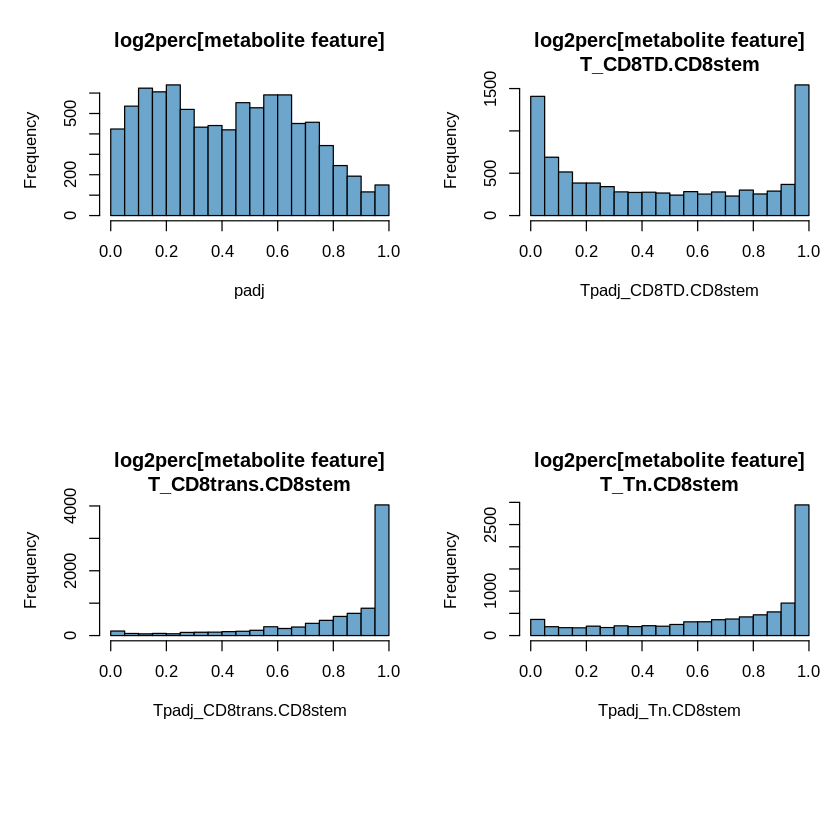

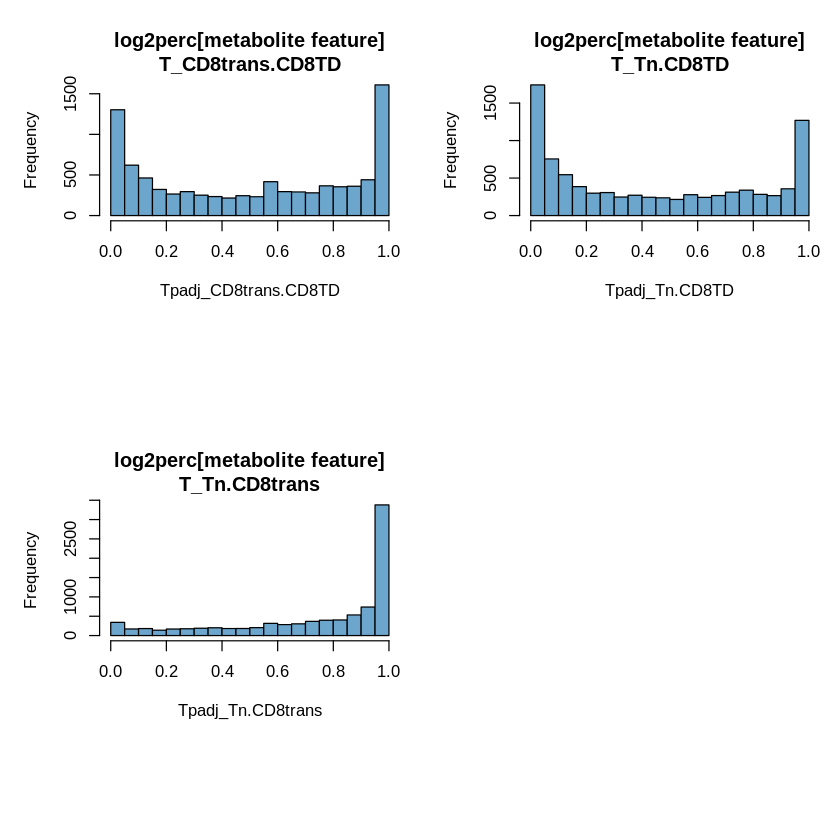

In [35]:
histogram_p(aov_tuk_df,'padj','\nlog2perc[metabolite feature]')

[1] "TFDR_CD8TD.CD8stem"    "TFDR_CD8trans.CD8stem" "TFDR_Tn.CD8stem"      
[4] "TFDR_CD8trans.CD8TD"   "TFDR_Tn.CD8TD"         "TFDR_Tn.CD8trans"     


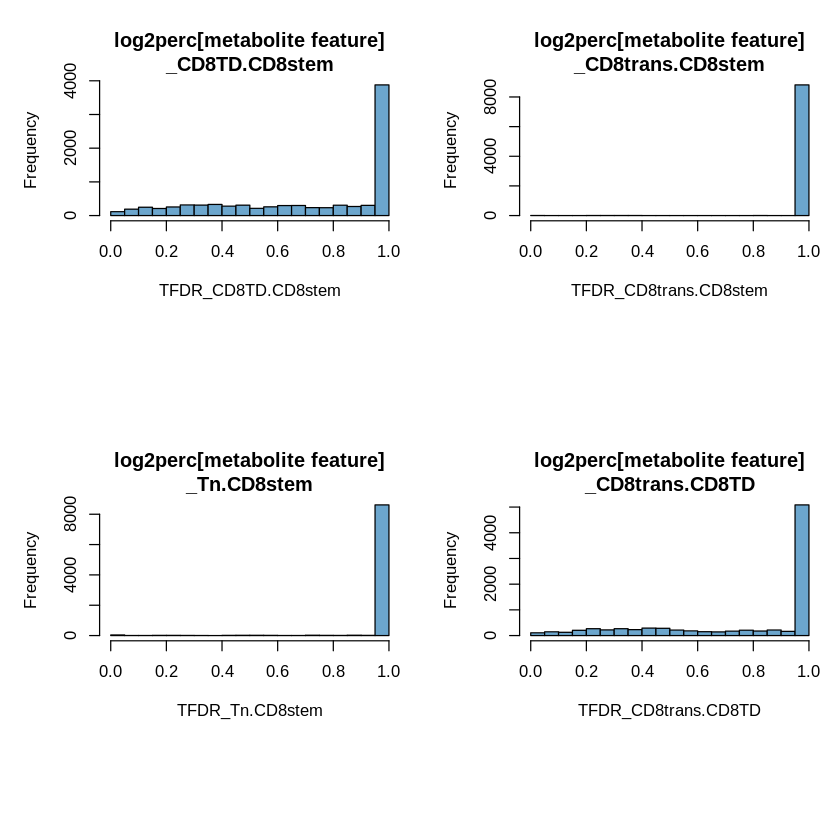

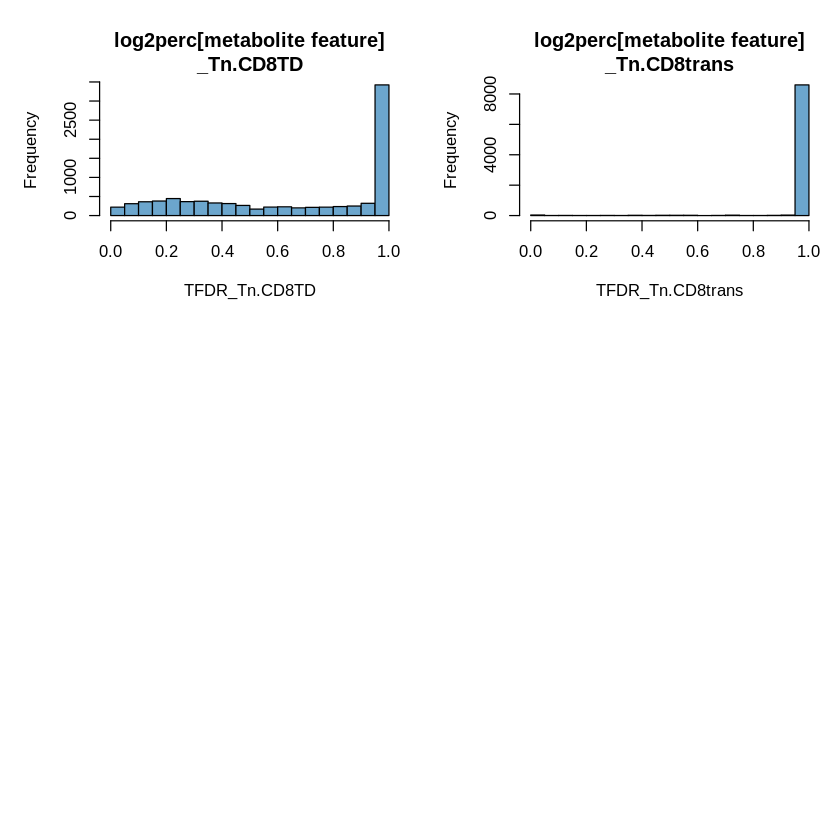

In [36]:
histogram_p(aov_tuk_df,'TFDR','\nlog2perc[metabolite feature]')

[1] "pval"


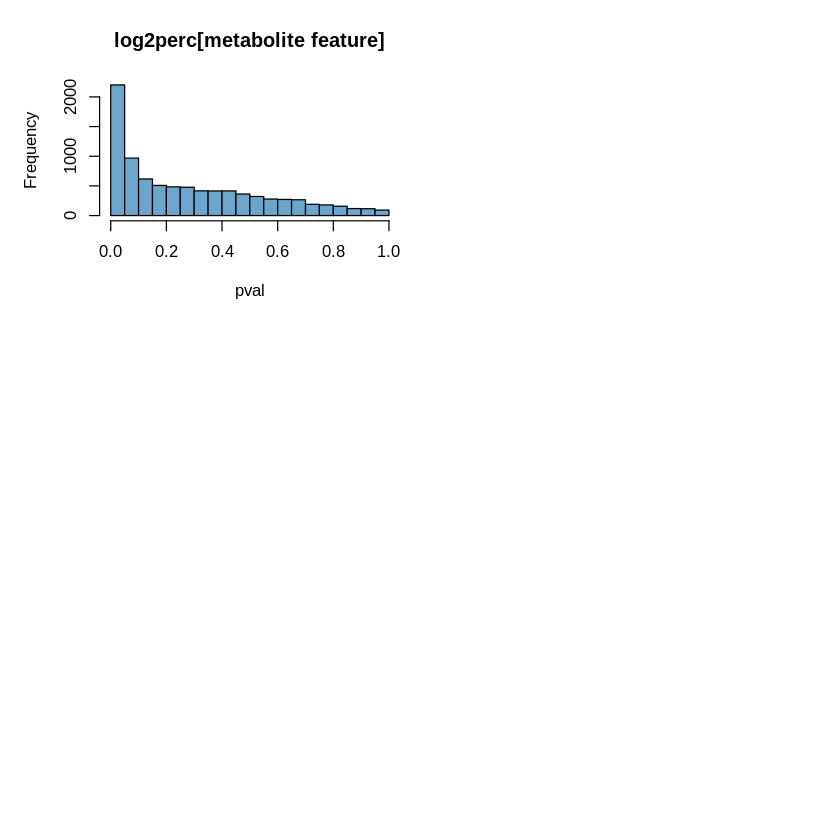

In [37]:
histogram_p(aov_tuk_df,'pval','\nlog2perc[metabolite feature]')

In [38]:
colnames(aov_tuk_df)

[1] "f_score"                "pval"                   "padj"                  
 [4] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
 [7] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"     
[10] "TFDR_CD8TD.CD8stem"     "TFDR_CD8trans.CD8stem"  "TFDR_Tn.CD8stem"       
[13] "TFDR_CD8trans.CD8TD"    "TFDR_Tn.CD8TD"          "TFDR_Tn.CD8trans"

In [39]:
sign_df = aov_tuk_df[(aov_tuk_df$padj < 0.05),]
sign_df[1:10,]

,f_score,pval,padj,Tpadj_CD8TD.CD8stem,Tpadj_CD8trans.CD8stem,Tpadj_Tn.CD8stem,Tpadj_CD8trans.CD8TD,Tpadj_Tn.CD8TD,Tpadj_Tn.CD8trans,TFDR_CD8TD.CD8stem,TFDR_CD8trans.CD8stem,TFDR_Tn.CD8stem,TFDR_CD8trans.CD8TD,TFDR_Tn.CD8TD,TFDR_Tn.CD8trans
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10076,38.38012,2.089701e-03,4.711808e-02,2.724206e-03,0.999890023,0.357604528,2.652895e-03,6.501247e-03,0.336379221,8.875703e-02,1.0000000,1.0000000,9.566166e-02,1.022170e-01,1.0000000
F10140,148.52220,1.479930e-04,1.150451e-02,1.762520e-04,0.081008678,0.265950570,3.622355e-04,2.681559e-04,0.614719349,2.296979e-02,1.0000000,1.0000000,3.689806e-02,2.241884e-02,1.0000000
F10142,56.08259,1.003285e-03,3.379470e-02,8.067609e-04,0.004342454,0.026870269,3.756918e-02,5.418226e-03,0.102828251,5.812614e-02,0.8361092,0.9601787,3.040530e-01,9.520307e-02,1.0000000
F10149,63.76411,7.812034e-04,3.049790e-02,1.225015e-03,1.000000000,1.000000000,1.225015e-03,1.225015e-03,1.000000000,6.349881e-02,1.0000000,1.0000000,6.759777e-02,4.934470e-02,1.0000000
F10184,1110.90838,2.693437e-06,9.233341e-04,9.888444e-07,0.994957845,0.998981657,9.308048e-07,9.546591e-07,0.999621732,6.740877e-04,1.0000000,1.0000000,5.891995e-04,3.845540e-04,1.0000000
F10185,7680.27781,5.648706e-08,7.997473e-05,9.370282e-14,0.901589433,0.713308944,9.370282e-14,9.370282e-14,0.402487762,2.075986e-10,1.0000000,1.0000000,2.075986e-10,9.543633e-11,1.0000000
F10186,479.05330,1.443094e-05,2.557740e-03,3.021869e-05,0.991166866,0.835094433,2.882174e-05,3.471334e-05,0.699314055,9.564216e-03,1.0000000,1.0000000,9.459934e-03,7.201394e-03,1.0000000
F10195,53.15198,1.113644e-03,3.537315e-02,4.920757e-03,0.161155585,0.036892837,2.302253e-02,8.706461e-04,0.006847803,1.147699e-01,1.0000000,1.0000000,2.428877e-01,4.297407e-02,0.4894468
F10250,55.55177,1.022021e-03,3.406073e-02,1.601217e-03,0.001601217,0.001601217,1.000000e+00,1.000000e+00,1.000000000,7.107734e-02,0.4099441,0.2166379,1.000000e+00,1.000000e+00,1.0000000


In [40]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.05,])[1]

[1] 424

In [41]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.1,])[1]

[1] 960

In [42]:
dim(aov_tuk_df[aov_tuk_df$pval < 0.05,])[1] # check raw p value

[1] 2202

-------

----

# construct the final result tables

In [43]:
detect_boundary_index = function(feat_df = feat_df,
                                 Data_RegExpr = '\\_[0-9]+'
                                ) {
    # the output index is the last index for the metainfo
    first_index4data = grep(Data_RegExpr,colnames(feat_df))[1]
    # range = colnames(feat_df)[first_index4data - 1:first_index4data + 1]
    print(colnames(feat_df)[first_index4data-1])
    return(first_index4data-1)
}

In [44]:
wrap_res2ful <- function(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index) {
    metainfo_df = feat_df[,1:end_index]
    metainfo_df = merge_by_rowName(metainfo_df,aov_tuk_df) # use merge by rowname in utilis
    m_df = merge_by_rowName(metainfo_df,
                 feat_df[(end_index + 1):ncol(feat_df)]) # use merge by rowname in utilis
    return(m_df)
}
    

In [45]:
metainfo_end_index = detect_boundary_index(feat_df = feat_df, 
                                           Data_RegExpr = '\\_[0-9]+')
full_res_df <- wrap_res2ful(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index)

[1] "log2FC_CD8TDvsCD8trans"


In [46]:
dim(full_res_df)

[1] 8862   36

In [47]:
colnames(full_res_df)

[1] "gMean_Tn"                 "gMean_CD8stem"           
 [3] "gMean_CD8trans"           "gMean_CD8TD"             
 [5] "log2FC_CD8stemvsTn"       "log2FC_CD8transvsTn"     
 [7] "log2FC_CD8TDvsTn"         "log2FC_CD8transvsCD8stem"
 [9] "log2FC_CD8TDvsCD8stem"    "log2FC_CD8TDvsCD8trans"  
[11] "f_score"                  "pval"                    
[13] "padj"                     "Tpadj_CD8TD.CD8stem"     
[15] "Tpadj_CD8trans.CD8stem"   "Tpadj_Tn.CD8stem"        
[17] "Tpadj_CD8trans.CD8TD"     "Tpadj_Tn.CD8TD"          
[19] "Tpadj_Tn.CD8trans"        "TFDR_CD8TD.CD8stem"      
[21] "TFDR_CD8trans.CD8stem"    "TFDR_Tn.CD8stem"         
[23] "TFDR_CD8trans.CD8TD"      "TFDR_Tn.CD8TD"           
[25] "TFDR_Tn.CD8trans"         "CD8TD_750K_1"            
[27] "CD8TD_750K_2"             "CD8stem_250K_1"          
[29] "CD8stem_300K_2"           "CD8trans_250K_2"         
[31] "CD8trans_350K_1"          "Tn_250K_1"               
[33] "Tn_250K_2"                "pooled_1"                
[35] "pooled_2"                 "pooled_3"

## output

In [48]:
output_fdr = glue('../../output/{exp_label}_1wayANOVA/')
dir.create(output_fdr)

In [49]:
write.csv(full_res_df,
          file.path(output_fdr, 
                    glue('one_wayANOVA_{exp_label}_fullreport.csv')))

------

------

------

In [50]:
col_stat_score = colnames(feat_df)[grep('log2FC',colnames(feat_df))]

In [51]:
col_stat_score

[1] "log2FC_CD8stemvsTn"       "log2FC_CD8transvsTn"     
[3] "log2FC_CD8TDvsTn"         "log2FC_CD8transvsCD8stem"
[5] "log2FC_CD8TDvsCD8stem"    "log2FC_CD8TDvsCD8trans"

In [52]:
col_padj_stat = colnames(aov_tuk_df)[grep('Tpadj',colnames(aov_tuk_df))]

In [53]:
col_padj_stat

[1] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
[4] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"

In [54]:
grepl('(CD8TD\\.|vs)CD8stem',col_padj_stat)

[1]  TRUE FALSE FALSE FALSE FALSE FALSE

In [55]:
grepl('CD8stem(\\.|vs)Tn',col_stat_score)

[1]  TRUE FALSE FALSE FALSE FALSE FALSE

In [56]:
# because this table don't have mz, rtime; fetch those information
annot_df = read.csv("../../../asari-output-RPneg/output_asari_project_31312361//Feature_annotation.tsv",
                sep = '\t')[,1:3]

In [57]:
annot_full_res_df = merge(annot_df,full_res_df,by.x = 'X.peak.id_number', by.y = 0, how = 'right')

In [58]:
rownames(annot_full_res_df) = annot_full_res_df[['X.peak.id_number']]

In [59]:
contrast_regExprs = c('(CD8TD(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8TD)', # Sometimes log2FC AvsB but padj can be BvsA
                      '(CD8trans(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8trans)',
                      '(CD8stem(\\.|vs)Tn)|(Tn(\\.|vs)CD8stem)',
                      '(CD8trans(\\.|vs)CD8TD)|(CD8TD(\\.|vs)CD8trans)',
                      '(Tn(\\.|vs)CD8TD)|(CD8TD(\\.|vs)Tn)',
                      '(Tn(\\.|vs)CD8trans)|(CD8trans(\\.|vs)Tn)')

res2mcg_tukey <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # Use log2FC as stat and padj/TFDR from tukey test for p cutoff
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        print(regExpr)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        # print(grep(glue("{stat_label}\\_{regExpr}"),coln))
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        print(strsplit(stat_col,'_')[[1]])
        true_label = strsplit(stat_col,'_')[[1]][2]
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [60]:
res2mcg_tukey(full_res_df = annot_full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

[1] "(CD8TD(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8TD)"
[1] "log2FC"         "CD8TDvsCD8stem"
[1] "(CD8trans(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8trans)"
[1] "log2FC"            "CD8transvsCD8stem"
[1] "(CD8stem(\\.|vs)Tn)|(Tn(\\.|vs)CD8stem)"
[1] "log2FC"      "CD8stemvsTn"
[1] "(CD8trans(\\.|vs)CD8TD)|(CD8TD(\\.|vs)CD8trans)"
[1] "log2FC"          "CD8TDvsCD8trans"
[1] "(Tn(\\.|vs)CD8TD)|(CD8TD(\\.|vs)Tn)"
[1] "log2FC"    "CD8TDvsTn"
[1] "(Tn(\\.|vs)CD8trans)|(CD8trans(\\.|vs)Tn)"
[1] "log2FC"       "CD8transvsTn"


## 2-steps to control tukey stat


In [61]:
res2mcg_tukey_2steps <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # With 2 steps, the data go after Tpadj, 
    # but turn to 1 if the feature didn't pass the 1-way ANOVA FDR
    # Use log2FC as stat and padj from tukey test for p cutoff
    
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2] # just quick way to get the contrast
        
        mcg_df[glue("org_{padj_col}")] = mcg_df[padj_col]
        mcg_df[mcg_df$padj > 0.05, padj_col] = 1
        
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_2steps_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [62]:
res2mcg_tukey_2steps(full_res_df = annot_full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

------

## Summary: normal one-way ANOVA
- with Tukey post-hoc test
- Run through all the contrast